In [1]:
from tensorflow.keras import models, layers, optimizers, callbacks, backend
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
matplotlib.rcParams['figure.dpi']=150
import time
import pickle
import sys

2023-06-02 23:57:42.510212: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/nicolas/miniconda3/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
#x_train = np.loadtxt("c_train.txt")  
#y_train = np.loadtxt("s_train.txt")  
#x_test = np.loadtxt("c_test.txt")  
#y_test = np.loadtxt("s_test.txt")  

w0 = np.loadtxt( "training/data/frequencies_nnps8.txt" )
X = np.loadtxt( "training/data/c_train_1_over_f_nnps8B.txt" )  
y = np.loadtxt( "training/data/s_train_1_over_f_nnps8B.txt" )  

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

print("x_train = ",np.shape(x_train))
print("y_train = ",np.shape(y_train))
print("x_test = ",np.shape(x_test))
print("y_test = ",np.shape(y_test))
print("w0 = ",np.shape(w0))

FileNotFoundError: training/data/frequencies_nnps8.txt not found.

In [17]:
def get_model( filter_nb, kernel_size, pool_size, learning_rate, dropout_rate ):
    model = models.Sequential()
    model.add( layers.Input( shape=(x_train.shape[-1], 1) ) )
    model.add( layers.Conv1D(filter_nb,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.Conv1D(filter_nb,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.MaxPooling1D( pool_size=pool_size, padding="same") )
    model.add( layers.Conv1D(filter_nb//2, kernel_size,activation="relu", padding='same' ) )
    model.add( layers.MaxPooling1D( pool_size=pool_size, padding="same") )
    model.add( layers.Conv1D(filter_nb//4,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.MaxPooling1D( pool_size=pool_size, padding="same") )
    
    model.add( layers.Conv1D( filter_nb//4,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.UpSampling1D( size=pool_size ) )
    model.add( layers.Conv1D( filter_nb//2,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.UpSampling1D( size=pool_size ) )
    model.add( layers.Conv1D( filter_nb,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.UpSampling1D( size=pool_size ) )
    
    model.add( layers.Conv1D( filter_nb,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.Conv1D( 1, kernel_size, activation="relu", padding='same' ) )
    model.add( layers.Flatten() )
    model.add( layers.Dropout( dropout_rate ) )
    model.add( layers.Dense(501, activation='linear') )
    
    opt = optimizers.Adam(learning_rate=learning_rate)
    #model.compile(loss='mean_squared_error', optimizer=opt)
    model.compile(loss='MAPE', optimizer=opt)
    
    return model 

In [7]:
model = get_model( filter_nb=80, kernel_size=48, pool_size=2,\
                          learning_rate=0.001, dropout_rate=0.05 )
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 147, 80)           3920      
                                                                 
 conv1d_9 (Conv1D)           (None, 147, 80)           307280    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 74, 80)           0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 74, 40)            153640    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 37, 40)           0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 37, 20)           

In [18]:
t1 = time.time()
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.25,patience=5,verbose=True,\
    mode="auto",min_delta=0.001,cooldown=0,min_lr=1e-6)

model = get_model( filter_nb=40, kernel_size=44, pool_size=2,\
                      learning_rate=0.001, dropout_rate=0.05 )
history_ = model.fit( x_train, y_train, 64, epochs=80,\
                         validation_data=(x_test, y_test), verbose=True, callbacks=[reduce_lr])

print(time.time()-t1)

Epoch 1/80
605/605 [==============================] - 24s 38ms/step - loss: 70.6052 - val_loss: 35.6558 - lr: 0.0010
Epoch 2/80
605/605 [==============================] - 22s 37ms/step - loss: 28.0456 - val_loss: 19.5118 - lr: 0.0010
Epoch 3/80
605/605 [==============================] - 22s 37ms/step - loss: 19.3616 - val_loss: 19.5501 - lr: 0.0010
Epoch 4/80
605/605 [==============================] - 22s 37ms/step - loss: 17.1876 - val_loss: 14.2323 - lr: 0.0010
Epoch 5/80
605/605 [==============================] - 22s 37ms/step - loss: 16.0374 - val_loss: 14.2735 - lr: 0.0010
Epoch 6/80
605/605 [==============================] - 22s 37ms/step - loss: 14.8457 - val_loss: 16.0637 - lr: 0.0010
Epoch 7/80
605/605 [==============================] - 22s 37ms/step - loss: 14.7950 - val_loss: 13.9329 - lr: 0.0010
Epoch 8/80
605/605 [==============================] - 22s 37ms/step - loss: 14.5614 - val_loss: 12.8133 - lr: 0.0010
Epoch 9/80
605/605 [==============================] - 23s 37ms/s

Epoch 65/80
605/605 [==============================] - 23s 37ms/step - loss: 8.5041 - val_loss: 8.3786 - lr: 3.9063e-06
Epoch 66/80
605/605 [==============================] - 23s 37ms/step - loss: 8.4970 - val_loss: 8.3616 - lr: 3.9063e-06
Epoch 67/80
605/605 [==============================] - 23s 37ms/step - loss: 8.4837 - val_loss: 8.3291 - lr: 3.9063e-06
Epoch 68/80
605/605 [==============================] - 23s 37ms/step - loss: 8.4807 - val_loss: 8.3236 - lr: 3.9063e-06
Epoch 69/80
605/605 [==============================] - 23s 37ms/step - loss: 8.4711 - val_loss: 8.3796 - lr: 3.9063e-06
Epoch 70/80
605/605 [==============================] - 23s 37ms/step - loss: 8.4789 - val_loss: 8.3628 - lr: 3.9063e-06
Epoch 71/80
605/605 [==============================] - 22s 37ms/step - loss: 8.4842 - val_loss: 8.3321 - lr: 3.9063e-06
Epoch 72/80
605/605 [==============================] - 22s 37ms/step - loss: 8.4945 - val_loss: 8.3215 - lr: 3.9063e-06
Epoch 73/80
605/605 [===================

In [16]:
plt.plot( range(1,80+1 ), np.array(history_.history['loss']), dashes=[2,2,2,2],label='loss', c='green')
plt.plot( range(1,80+1 ), np.array(history_.history['val_loss']), label = 'val_loss', c='green')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0)
#plt.legend(loc='lower right')

NameError: name 'history_' is not defined

In [4]:
label1 = 'number_of_filters'
label2 = 'kernel_size'

parameters1_arr = np.arange( 12,81,1 )  #-- number of filters
parameters2_arr = np.arange( 3,65,1 )  #-- kernel size
batch_size_size_arr = [32, 64]
pairs = []
for p1 in parameters1_arr:
    for p2 in parameters2_arr:
        pairs.append([p1,p2])
        
training_losses = {}
validation_losses = {}

nb_of_points = len(parameters1_arr)*len(parameters2_arr)
print(label1, parameters1_arr)
print(label2, parameters2_arr)
print(len(parameters1_arr),len(parameters2_arr),nb_of_points)

number_of_filters [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80]
kernel_size [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64]
69 62 4278


In [ ]:
epochs=40
best_loss = 1000
worst_loss = -1

t1=time.time()
print('-- nb of points =',nb_of_points )

from datetime import datetime
now = datetime.now()
t_string = now.strftime("%d_%m||%Hh%M")

if (nb_of_points != len(pairs)):
    print("-- ABORT: parameter sweep already started.")
    sys.exit()


count=0
while pairs:
    
    count +=1
    rand_int = np.random.randint(0, len(pairs))
    pair = pairs[rand_int]
    p1 = int( pair[0] )
    p2 = int( pair[1] )
    pairs.remove(pair)

    print('.',end=' ' )
    
    for bs in batch_size_size_arr:
        
        reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.25,patience=5,verbose=0,\
            mode="auto",min_delta=0.001,cooldown=0,min_lr=1e-6)
        model = get_model( filter_nb=p1, kernel_size=p2, pool_size=2,\
                          learning_rate=0.001, dropout_rate=0.05 )
        history_ = model.fit( x_train, y_train, bs, epochs=epochs,\
                             validation_data=(x_test, y_test), verbose=0, callbacks=[reduce_lr])

        training_losses[ p1 , p2, bs ] = history_.history['loss'][-1]
        validation_losses[ p1 ,p2, bs ] = history_.history['val_loss'][-1]
        if count > 1:
            with open('training/training_losses_'+t_string+'.pkl', 'wb') as f1:
                pickle.dump(training_losses, f1)
            with open('training/validation_losses_'+t_string+'.pkl', 'wb') as f2:
                pickle.dump(validation_losses, f2)

        if (validation_losses[ p1 , p2, bs ] < best_loss):
            model.save('training/best_model_'+t_string, overwrite=True)
            with open('training/best_history_'+t_string+'.pkl', 'wb') as f3:
                pickle.dump(history_.history, f3)
            best_loss = validation_losses[ p1 , p2, bs ]
            best_p1=p1
            best_p2=p2
        
        del model
        del history_
        

t2=time.time()
print(' ')
print('=== COMPLETE ===')
print("-- total time = ", t2-t1)
print("-- best {}, {} =".format(label1, label2), best_p1, best_p2)
print("-- t_string", t_string)


-- nb of points = 4278
. 

INFO:tensorflow:Assets written to: training/best_model_27_04||14h17/assets


INFO:tensorflow:Assets written to: training/best_model_27_04||14h17/assets


. 

INFO:tensorflow:Assets written to: training/best_model_27_04||14h17/assets


INFO:tensorflow:Assets written to: training/best_model_27_04||14h17/assets


INFO:tensorflow:Assets written to: training/best_model_27_04||14h17/assets


INFO:tensorflow:Assets written to: training/best_model_27_04||14h17/assets


. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

Best parameters = number_of_filters kernel_size dr = 78 49 64 8.4396333694458


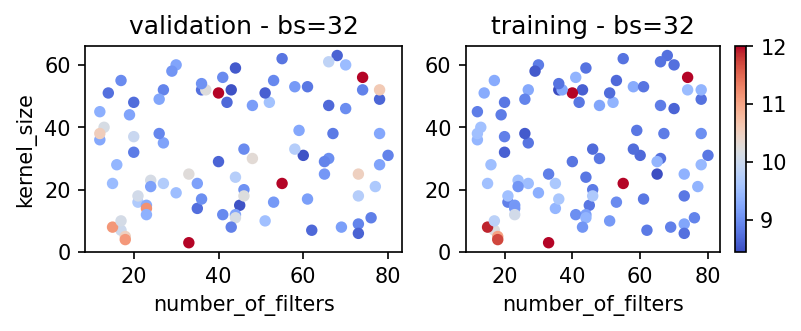

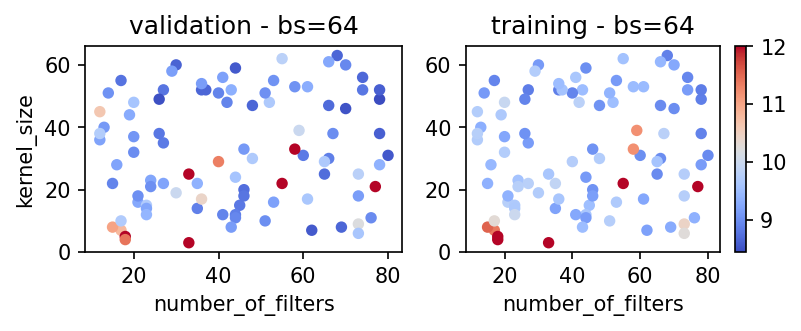

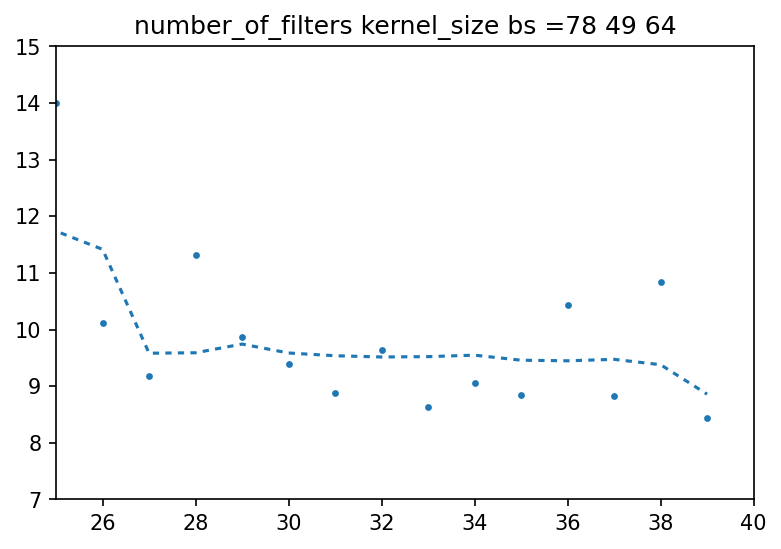

In [11]:
from collections import defaultdict

matplotlib.rcParams['figure.dpi']=150
t_string="27_04||14h17"
with open('training/training_losses_'+t_string+'.pkl', 'rb') as f1:
    training_losses = pickle.load(f1)
with open('training/validation_losses_'+t_string+'.pkl', 'rb') as f2:
    validation_losses = pickle.load(f2)
with open('training/best_history_'+t_string+'.pkl', 'rb') as f3:
    best_history = pickle.load(f3)


min_val = min(validation_losses, key=validation_losses.get)
print( "Best parameters = "+label1+" "+label2+' dr =', min_val[0], min_val[1],min_val[2],validation_losses[min_val] )

#x_scatter = [ x[0] for x in training_losses]
#y_scatter = [ x[1] for x in training_losses]

x_scatter = defaultdict(list)
y_scatter = defaultdict(list)
training_colors = defaultdict(list)
validation_colors = defaultdict(list)
for x in training_losses:
    x_scatter[x[2]].append(x[0])
    y_scatter[x[2]].append(x[1])
    training_colors[x[2]].append( training_losses[x]  )
    validation_colors[x[2]].append( validation_losses[x]  )


#training_colors = [training_losses[x] for x in training_losses]
#validation_colors = [validation_losses[x] for x in training_losses]


for key in x_scatter.keys():
    
    vals = list(validation_losses.values())
    
    plt.subplot(2,2,1)
    mycmap = plt.cm.coolwarm
    lognorm=matplotlib.colors.LogNorm()
    #plt.scatter( x_scatter, y_scatter, s=20, c=validation_colors, cmap=mycmap)#,norm=lognorm )
    plt.scatter( x_scatter[key], y_scatter[key], s=20, c=validation_colors[key], cmap=mycmap)#,norm=lognorm )
    plt.xlabel(label1)
    plt.ylabel(label2)
    #plt.clim( min(vals), max(vals) )
    plt.clim( min(vals), 12 )
    plt.title( 'validation - bs='+str(key) )

    plt.subplot(2,2,2)
    lognorm=matplotlib.colors.LogNorm()
    mycmap = plt.cm.coolwarm
    plt.scatter( x_scatter[key], y_scatter[key], s=20, c=training_colors[key], cmap=mycmap)#,norm=lognorm )
    plt.xlabel(label1)
    plt.title( 'training - bs='+str(key) )
    plt.clim( min(vals), 12 )
    #plt.clim( min(vals), max(vals) )
    plt.colorbar()
    
    plt.show()

plt.scatter( np.arange(len(best_history['val_loss'])), best_history['val_loss'], s=5 )
plt.plot( np.arange(len(best_history['loss'])), best_history['loss'], dashes=[2,2,2,2] )
plt.savefig('training/plots/'+t_string+'.pdf',format='pdf')
plt.title( label1+" "+label2+' bs ='+str(min_val[0])+" "+str(min_val[1])+" "+str(min_val[2]) )
plt.xlim(25,40)
plt.ylim(7,15)
plt.show()

In [13]:
reconstructed_model = models.load_model('training/best_model_'+t_string)

In [14]:
probability_model = tf.keras.Sequential([reconstructed_model])
predictions_best = probability_model.predict(x_test)

214/214 [==============================] - 7s 23ms/step


(0.0, 500000.0)

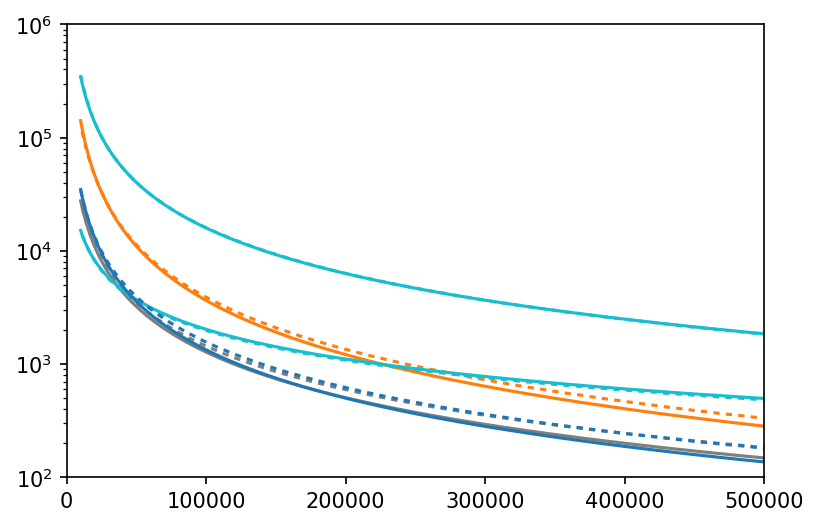

In [15]:
plt.subplot(1, 1, 1)
rand_set = np.random.randint( 0, y_test.shape[0] ,(5,) )
for i in rand_set:
    plt.plot(w0,y_test[i,:],color='C'+str(i))
    plt.plot(w0,predictions_best[i],dashes=[2,2,2,2],color='C'+str(i))
plt.yscale('log')
plt.ylim(1e2,1e6)
plt.xlim(0,0.5e6)

In [ ]:
matplotlib.rcParams['figure.dpi']=300
plt.subplot(1, 2, 1)
rand_set = np.random.randint( 0, y_test.shape[0] ,(30,) )
for i in rand_set:
    plt.plot(w0,y_test[i,:],color='C'+str(i))
    #plt.plot(w0,predictions_best[i],dashes=[2,2,2,2],color='C'+str(i))
plt.yscale('log')

plt.subplot(1, 2, 2)
for i in rand_set:
    plt.plot( x_test[i,:],color='C'+str(i))
    #plt.plot(w0,predictions_best[i],dashes=[2,2,2,2],color='C'+str(i))

In [37]:
validation_losses

{(52, 29): 12.280069351196289,
 (28, 22): 10.445279121398926,
 (69, 15): 10.662707328796387,
 (74, 40): 11.924968719482422,
 (79, 12): 11.903802871704102,
 (20, 28): 14.10513687133789,
 (75, 15): 11.984048843383789,
 (49, 45): 98.20396423339844,
 (49, 29): 11.42209243774414,
 (35, 25): 12.064530372619629,
 (66, 43): 12.12700366973877,
 (70, 43): 12.222420692443848,
 (50, 22): 10.957698822021484,
 (71, 31): 10.522311210632324,
 (21, 39): 11.283363342285156,
 (61, 17): 10.31566047668457,
 (67, 12): 11.425739288330078,
 (60, 31): 11.928427696228027,
 (40, 30): 14.074586868286133,
 (74, 46): 11.207980155944824,
 (64, 35): 13.250297546386719,
 (60, 13): 98.2032241821289,
 (29, 30): 10.291311264038086,
 (76, 28): 9.786140441894531,
 (43, 12): 11.449771881103516,
 (31, 32): 11.71078872680664,
 (22, 34): 10.182755470275879,
 (23, 28): 10.582271575927734,
 (59, 12): 10.978233337402344,
 (28, 46): 11.145133018493652,
 (52, 23): 12.15572738647461,
 (63, 18): 10.908235549926758,
 (66, 45): 10.6175

In [39]:
validation_losses[40,44]

9.446722030639648

In [45]:
mmin=min(validation_losses, key=validation_losses.get)

(20, 28)

In [22]:
from collections import defaultdict
  
  
# Defining a dict
d = defaultdict(list)
  
for i in range(5):
    d[i].append(i)
      
print("Dictionary with values as list:")
print(d)

Dictionary with values as list:
defaultdict(<class 'list'>, {0: [0], 1: [1], 2: [2], 3: [3], 4: [4]})


In [23]:
for key in d.keys():
    print(key)

0
1
2
3
4


In [31]:
validation_losses

{(32, 36, 64): 45.28209686279297,
 (32, 36, 254): 84.0857925415039,
 (94, 32, 64): 55.39064407348633,
 (94, 32, 254): 82.19808197021484,
 (26, 20, 64): 38.67766571044922,
 (26, 20, 254): 73.27628326416016}

In [32]:
x_scatter

defaultdict(list, {64: [32, 94, 26], 254: [32, 94, 26]})